In [42]:
import math
import pandas as pd
import numpy as np
import scipy.stats as st
from matplotlib import pyplot as plt
from tqdm import tqdm

In [33]:
data = pd.read_csv('data/warfarin.csv')
data = data[data['Therapeutic Dose of Warfarin'].notnull()]

In [34]:
data = data.reset_index(drop=True) # fix weird row indexing 

In [35]:
def assign_bucket(n):
    if n < 21:
        return 0
    elif n > 49:
        return 2
    else:
        return 1


In [36]:
# Create a feauture vector using the features described in S1e of appx.pdf (features used in Baseline 2)
def create_feature_vec_S1e(row):
    x = np.zeros([8,1])
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        x[0] = int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        x[1] = height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        x[2] = weight 
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        x[3] = 1
    if race == 'Black or African American':
        x[4] = 1
    if race == 'Unknown':
        x[5] = 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        x[6] = 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        x[7] = 1
    
    return x



In [37]:
# Create a feature vector using the features described in S1f of appx.pdf (features used in Baseline 3)
def create_feature_vec_S1f(row):
    x = np.zeros([17,1])
    index = row.index[0]
    
    # Age 
    age =  row.loc[index, 'Age']
    if type(age) != float:
        x[0] = int(age[0])
    
    # Height 
    height = row.loc[index,'Height (cm)']
    if not math.isnan(height):
        x[1] = height
    
    # Weight 
    weight = row.loc[index,'Weight (kg)']
    if not math.isnan(weight):
        x[2] = weight 

    # VKORC1 
    vkorc1_ag = row.loc[index, 'VKORC1 genotype: -1639 G>A (3673); chr16:31015190; rs9923231; C/T']
    if type(vkorc1_ag) != float:
        if vkorc1_ag == 'A/G':
            x[3] = 1
        if vkorc1_ag == 'A/A':
            x[4] = 1
        if vkorc1_ag == 'NA':
            x[5] = 1
    
    # CYP2C9 
    cyp2c9 = row.loc[index, 'Cyp2C9 genotypes']
    if type(cyp2c9) != float:
        if cyp2c9 == '*1/*2':
            x[6] = 1
        if cyp2c9 == '*1/*3':
            x[7] = 1
        if cyp2c9 == '*2/*2':
            x[8] = 1
        if cyp2c9 == '*2/*3':
            x[9] = 1
        if cyp2c9 == '*3/*3':
            x[10] = 1
        if cyp2c9 == 'NA':
            x[11] = 1
    
    race = row.loc[index,'Race']
    # Race
    if race == 'Asian':
        x[12] = 1
    if race == 'Black or African American':
        x[13] = 1
    if race == 'Unknown':
        x[14] = 1

    # enzyme inducer 
    carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
    phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
    rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0

    if carbamazepine or phenytoin or rifampin:
        x[15] = 1
    
    # amiodarone 
    amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
    if amiodarone: 
        x[16] = 1
    
    return x



In [38]:
def compute_dose_baseline2(row):
    index = row.index[0]
    def get_age_bucket(row):
        age =  row.loc[index, 'Age']
        if type(age) != float:
            return int(age[0])
        else: return 0


    def race_weight(row):
        race = row.loc[index,'Race']
        if race == 'Asian':
            return -.6752
        elif race == 'Black or African American':
            return .4060
        elif race == 'Unknown':
            return .0443
        else:
            return 0
    
    def enzyme_inducer(row):
        carbamazepine = int(row.loc[index,'Carbamazepine (Tegretol)']) if not math.isnan(row.loc[index,'Carbamazepine (Tegretol)']) else 0
        phenytoin = int(row.loc[index,'Phenytoin (Dilantin)']) if not math.isnan(row.loc[index,'Phenytoin (Dilantin)']) else 0
        rifampin = int(row.loc[index,'Rifampin or Rifampicin']) if not math.isnan(row.loc[index,'Rifampin or Rifampicin']) else 0
        if carbamazepine or phenytoin or rifampin:
            return 1
        else:
            return 0
    
    def amidarone(row):
        amiodarone = int(row.loc[index,'Amiodarone (Cordarone)']) if not math.isnan(row.loc[index,'Amiodarone (Cordarone)']) else 0
        if amidarone: 
            return 1
        else: 
            return 0
        

    total = 4.0376
    total -= 0.2546 * get_age_bucket(row) 
    total += 0.0118 * row.loc[index,'Height (cm)']
    total += 0.0134 * row.loc[index,'Weight (kg)']
    total += race_weight(row) 
    total += 1.2799 * enzyme_inducer(row)
    total -= 0.5695 * amidarone(row)
    
    return total * total


In [105]:
# Generate pd Series of correct doses ([0,2])
doses = data['Therapeutic Dose of Warfarin']
doses = doses.apply(lambda dose : assign_bucket(dose)).to_numpy()
print(len(doses))
print(len(data))

5528
5528


In [104]:
num_wrong = (doses != 1).sum()
print(f"Performance of baseline 1: {round(num_wrong / len(Y), 4)}")

Performance of baseline 1: 0.3882


In [117]:
T = len(data)
num_a = 3

# Baseline 1
baseline1_rs = np.zeros((20,T))
baseline1_actions = np.zeros((20,T))

# Baseline 2 
baseline2_rs = np.zeros((20,T))
baseline2_actions = np.zeros((20,T))

# LinUCB S1e features 
linucb1_rs = np.zeros((20,T))
linucb1_actions = np.zeros((20,T))
linucb1_d = 8
linucb1_alpha = 1 
linucb1_A_list = [np.identity(linucb1_d), np.identity(linucb1_d), np.identity(linucb1_d)]
linucb1_b_list = [np.zeros([linucb1_d,1]), np.zeros([linucb1_d,1]), np.zeros([linucb1_d,1])]

# LinUCB S1f features 
linucb2_rs = np.zeros((20,T))
linucb2_actions = np.zeros((20,T))
linucb2_d = 17
linucb2_alpha = 1 
linucb2_A_list = [np.identity(linucb2_d), np.identity(linucb2_d), np.identity(linucb2_d)]
linucb2_b_list = [np.zeros([linucb2_d,1]), np.zeros([linucb2_d,1]), np.zeros([linucb2_d,1])]

# Thompson Sampling 1
tsamp1_rs = np.zeros((20,T))
tsamp1_actions = np.zeros((20,T))
tsamp1_d = 8
tsamp1_R = 1
tsamp1_eps = 1 / np.log(T)
tsamp1_delta = .1
tsamp1_v = 0.2 #tsamp1_R * np.sqrt(24 / tsamp1_eps * tsamp1_d * np.log(1 / tsamp1_delta))

tsamp1_B_list = [np.identity(tsamp1_d), np.identity(tsamp1_d), np.identity(tsamp1_d)]
tsamp1_mu_hat_list = [np.zeros(tsamp1_d), np.zeros(tsamp1_d), np.zeros(tsamp1_d)]
tsamp1_f_list = [np.zeros(tsamp1_d), np.zeros(tsamp1_d), np.zeros(tsamp1_d)]

# Thompson Sampling 2
tsamp2_rs = np.zeros((20,T))
tsamp2_actions = np.zeros((20,T))
tsamp2_d = 17
tsamp2_R = 1
tsamp2_eps = 1 / np.log(T)
tsamp2_delta = .1
tsamp2_v = 0.2 #tsamp2_R * np.sqrt(24 / tsamp2_eps * tsamp2_d * np.log(1 / tsamp2_delta))

tsamp2_B_list = [np.identity(tsamp2_d), np.identity(tsamp2_d), np.identity(tsamp2_d)]
tsamp2_mu_hat_list = [np.zeros(tsamp2_d), np.zeros(tsamp2_d), np.zeros(tsamp2_d)]
tsamp2_f_list = [np.zeros(tsamp2_d), np.zeros(tsamp2_d), np.zeros(tsamp2_d)]

# Do 20 runs 
for i in tqdm(range(20)):
    # LinUCB - reset A and b lists
    linucb1_A_list = [np.identity(linucb1_d), np.identity(linucb1_d), np.identity(linucb1_d)]
    linucb1_b_list = [np.zeros([linucb1_d,1]), np.zeros([linucb1_d,1]), np.zeros([linucb1_d,1])]

    linucb2_A_list = [np.identity(linucb2_d), np.identity(linucb2_d), np.identity(linucb2_d)]
    linucb2_b_list = [np.zeros([linucb2_d,1]), np.zeros([linucb2_d,1]), np.zeros([linucb2_d,1])]
    # Loop over all timesteps T in dataset 
    for t in range(T):
        # Sample random row 
        row = data.sample(replace=False)
        # row = data.loc[[t]]
        
        # Get correct action
        correct_dose = doses[row.index[0]]

        # Baseline 1 
        b1_a = 1
        baseline1_actions[i,t] = b1_a
        b1_r = 0 if correct_dose == b1_a else -1
        baseline1_rs[i,t] = b1_r

        # Baseline 2
        b2_a = assign_bucket(compute_dose_baseline2(row))
        baseline2_actions[i, t] = assign_bucket(b2_a) 
        b2_r = 0 if correct_dose == b2_a else -1
        baseline2_rs[i, t] =b2_r

        # LinUCB 1
        x = create_feature_vec_S1e(row)

        p = np.zeros(num_a)
        for a in range(num_a):
            A = linucb1_A_list[a]
            b = linucb1_b_list[a]
            A_inv = np.linalg.inv(A)
            theta = A_inv @ b
            p[a] = theta.T @ x + linucb1_alpha * np.sqrt(x.T @ A_inv @ x)
        
        linucb1_a = np.argmax(p)
        linucb1_actions[i,t] = linucb1_a
        linucb1_r = 0 if correct_dose == linucb1_a else -1
        linucb1_rs[i, t] = linucb1_r

        linucb1_A_list[linucb1_a] = linucb1_A_list[linucb1_a] + x @ x.T
        linucb1_b_list[linucb1_a] = linucb1_b_list[linucb1_a] + linucb1_r * x

        # LinUCB 2
        x = create_feature_vec_S1f(row)

        p = np.zeros(num_a)
        for a in range(num_a):
            A = linucb2_A_list[a]
            b = linucb2_b_list[a]
            A_inv = np.linalg.inv(A)
            theta = A_inv @ b
            p[a] = theta.T @ x + linucb2_alpha * np.sqrt(x.T @ A_inv @ x)
        
        linucb2_a = np.argmax(p)
        linucb2_actions[i,t] = linucb2_a
        linucb2_r = 0 if correct_dose == linucb2_a else -1
        linucb2_rs[i, t] = linucb2_r

        linucb2_A_list[linucb2_a] = linucb2_A_list[linucb2_a] + x @ x.T
        linucb2_b_list[linucb2_a] = linucb2_b_list[linucb2_a] + linucb2_r * x
        
        # Thompson Sampling 1
        x = create_feature_vec_S1e(row)
        mu_tildes = [np.random.multivariate_normal(mu_hat, tsamp1_v * tsamp1_v * np.linalg.inv(B)) for mu_hat, B in zip(tsamp1_mu_hat_list, tsamp1_B_list)]
        arm_scores = [x.T @ mu_tilde for mu_tilde in mu_tildes]

        tsamp1_a = np.argmax(arm_scores)
        tsamp1_actions[i,t] = tsamp1_a
        tsamp1_r = 0 if correct_dose == tsamp1_a else -1
        tsamp1_rs[i, t] = tsamp1_r    

        tsamp1_B_list[tsamp1_a] += x @ x.T
        tsamp1_f_list[tsamp1_a] += x.squeeze() * tsamp1_r
        tsamp1_mu_hat_list[tsamp1_a] = np.linalg.inv(tsamp1_B_list[tsamp1_a]) @ tsamp1_f_list[tsamp1_a]

        # Thompson Sampling 2 
        x = create_feature_vec_S1f(row)
        mu_tildes = [np.random.multivariate_normal(mu_hat, tsamp2_v * tsamp2_v * np.linalg.inv(B)) for mu_hat, B in zip(tsamp2_mu_hat_list, tsamp2_B_list)]
        arm_scores = [x.T @ mu_tilde for mu_tilde in mu_tildes]

        tsamp2_a = np.argmax(arm_scores)
        tsamp2_actions[i,t] = tsamp2_a
        tsamp2_r = 0 if correct_dose == tsamp2_a else -1
        tsamp2_rs[i, t] = tsamp2_r    

        tsamp2_B_list[tsamp1_a] += x @ x.T
        tsamp2_f_list[tsamp1_a] += x.squeeze() * tsamp1_r
        tsamp2_mu_hat_list[tsamp1_a] = np.linalg.inv(tsamp2_B_list[tsamp1_a]) @ tsamp2_f_list[tsamp1_a]

100%|██████████| 20/20 [06:02<00:00, 18.11s/it]


In [118]:
np.savetxt('baseline1_rs.txt', baseline1_rs)
np.savetxt('baseline2_rs.txt', baseline2_rs)
np.savetxt('linucb1_rs.txt', linucb1_rs)
np.savetxt('linucb2_rs.txt', linucb2_rs)
np.savetxt('tsamp1_rs.txt', tsamp1_rs)
np.savetxt('tsamp2_rs.txt', tsamp2_rs)

In [112]:
print(np.sum(baseline1_rs[2,:]) / np.size(baseline1_rs, 1))

-0.3905571635311143


In [119]:
def plot_regret_wrong(rewards, ax_regret, ax_incorrect, label, color):
    """ Compute the cumulative regret over time and the percent of wrong actions over time and plot
        with 95% confidence intervals using t distribution. 

        rewards: np array of size (20,T) """
    regret = np.cumsum(rewards, axis=1)
    mean_regret = np.mean(regret, axis=0)
    frac_incorrect = np.abs(regret) / np.linspace(0,np.size(rewards,1), num = np.size(rewards,1))
    mean_frac_incorrect = np.mean(frac_incorrect, axis=0)

    regret_int_upper = []
    regret_int_lower = []
    incorrect_int_upper = []
    incorrect_int_lower = []

    for t in range(np.size(rewards,1)):
        regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[t], scale= st.sem(regret[:,t]))
        regret_int_upper.append(regret_bounds[1])
        regret_int_lower.append(regret_bounds[0])

        incorrect_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_frac_incorrect[t], scale= st.sem(frac_incorrect[:,t]))
        incorrect_int_upper.append(incorrect_bounds[1])
        incorrect_int_lower.append(incorrect_bounds[0])
    
    ts = np.linspace(0,np.size(rewards,1), num = np.size(rewards,1))
    ax_regret.plot(ts, mean_regret, label=label, color=color)
    ax_regret.fill_between(ts,regret_int_lower, regret_int_upper, color=color, alpha = 0.3)
    ax_incorrect.plot(ts, mean_frac_incorrect, label=label, color=color)
    ax_incorrect.fill_between(ts, incorrect_int_lower, incorrect_int_upper, color=color, alpha = 0.3)


In [73]:
regret = np.cumsum(baseline1_rs, axis=1)
mean_regret = np.mean(regret, axis=0)
regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[5], scale= st.sem(regret[:,5]))

print(mean_regret[5])
print(st.sem(regret[:,5]))
print(regret_bounds)

-0.3
0.10513149660756935
(-0.5200427512755833, -0.07995724872441665)


/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/3337712535.py:3: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[5], scale= st.sem(regret[:,5]))


/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/1400616751.py:8: RuntimeWarning: divide by zero encountered in true_divide
  frac_incorrect = np.abs(regret) / np.linspace(0,np.size(rewards,1), num = np.size(rewards,1))
/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/1400616751.py:8: RuntimeWarning: invalid value encountered in true_divide
  frac_incorrect = np.abs(regret) / np.linspace(0,np.size(rewards,1), num = np.size(rewards,1))
/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/1400616751.py:17: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first positional argument or keyword argument `confidence` instead.
  regret_bounds = st.t.interval(alpha= 0.95, df=20-1, loc=mean_regret[t], scale= st.sem(regret[:,t]))
/var/folders/zb/sy9wjhxn28nf5206tqm0lh400000gn/T/ipykernel_31800/1400616751.py:21: DeprecationWarning: Use of keyword argument `alpha` for method `interval` is deprecated. Use first p

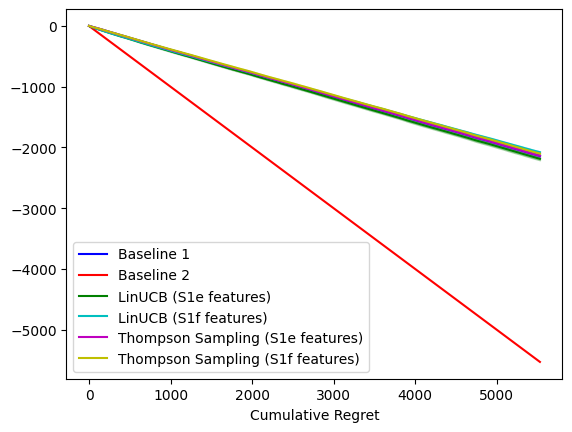

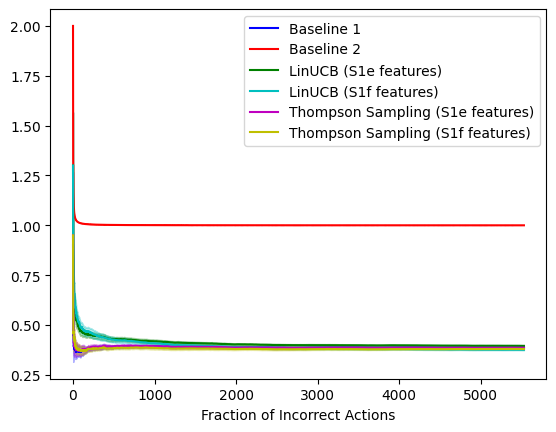

In [120]:
# plotting 
fig1, ax1 = plt.subplots()
fig2, ax2  = plt.subplots()
ax1.set_xlabel('Timestep t')
ax2.set_xlabel('Timestep t')
ax1.set_xlabel('Cumulative Regret')
ax2.set_xlabel('Fraction of Incorrect Actions')

plot_regret_wrong(baseline1_rs, ax1, ax2, 'Baseline 1', 'b')
plot_regret_wrong(baseline2_rs, ax1, ax2, 'Baseline 2', 'r')
plot_regret_wrong(linucb1_rs, ax1, ax2, 'LinUCB (S1e features)', 'g')
plot_regret_wrong(linucb2_rs, ax1, ax2, 'LinUCB (S1f features)', 'c')
plot_regret_wrong(tsamp1_rs, ax1, ax2, 'Thompson Sampling (S1e features)', 'm')
plot_regret_wrong(tsamp2_rs, ax1, ax2, 'Thompson Sampling (S1f features)', 'y')

ax1.legend()
ax2.legend()
plt.show()